In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler

def scaled_trainer(arr, lb, lf, choice):
    sc = MinMaxScaler(feature_range=(-1,1))
    tx = np.array([])
    ty = np.array([])
    t = np.array([])

    for i in arr:
        data = pd.read_csv(i).filter([choice]).values
        data = sc.fit_transform(data)
        t = np.append(t, sliding_window_view(data, window_shape = (lb+lf,1)))

    t = t.reshape(int(t.shape[0]/(lb+lf)), lb+lf)
    for j in t:
        tx = np.append(tx, j[:lb])
        ty = np.append(ty, j[lb:])
    tx = tx.reshape((int(tx.shape[0]/lb), lb))
    ty = sc.inverse_transform(ty.reshape((-1,1)))       
    ty = ty.reshape((int(ty.shape[0]/lf), lf))

    return tx, ty

In [ ]:
#Limits on number of days taken as input(lb) and number of days taken as output(lf)
lb=200
lf=10
#List of companies to train on:
#1 and 3 for training, 2 for testing
companies = ["reliance industries.csv", "reliance power.csv", "tata steel.csv",
             "asian paints new.csv", "tata coffee.csv", "edelweiss.csv", 
             "tata chemicals.csv", "tech mahindra.csv", "infosys.csv", "tata motors.csv"]

In [ ]:
slopes = np.arange(-5,5).reshape((-1,2))
model_out = []
for i in slopes:
    if i[0]<=0:
        model_out.append(0)
    else:
        model_out.append(1)
    if i[1]<=0:
        model_out.append(0)
    else:
        model_out.append(1)
model_out = np.array(model_out)
model_out = model_out.reshape((int(model_out.shape[0]/2), 2))
model_out, slopes

(array([[0, 0],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1]]),
 array([[-5, -4],
        [-3, -2],
        [-1,  0],
        [ 1,  2],
        [ 3,  4]]))

In [ ]:
for com in companies:
    trade_x, _ = scaled_trainer([com], lb, lf, "No. of Trades")
    shl_x, _ = scaled_trainer([com], lb, lf, "Spread High-Low")
    date_x, _ = scaled_trainer([com], lb, lf, "Date_val")
    wap_x, wap_y = scaled_trainer([com], lb, lf, "WAP")
    share_x, _ = scaled_trainer([com], lb, lf, "No.of Shares")
    sco_x, _ = scaled_trainer([com], lb, lf, "Spread Close-Open")
    open_x, _ = scaled_trainer([com], lb, lf, "Open Price")
    
    model_in = wap_x.reshape((-1,200,1))
    model_in = np.append(model_in, open_x.reshape((-1,200,1)), axis=2)
    model_in = np.append(model_in, shl_x.reshape((-1,200,1)), axis=2)
    model_in = np.append(model_in, sco_x.reshape((-1,200,1)), axis=2)
    model_in = np.append(model_in, trade_x.reshape((-1,200,1)), axis=2)
    model_in = np.append(model_in, share_x.reshape((-1,200,1)), axis=2)
    model_in = np.append(model_in, date_x.reshape((-1,200,1)), axis=2)

    x = np.arange(1,lf+1)
    slopes = np.array([])
    direction = np.array([])
    for i in wap_y:
        m, _ = np.polyfit(x, i, 1)
        a, b, _ = np.polyfit(x, i, 2)
        slopes = np.append(slopes, np.array([m, a]))

    slopes = slopes.reshape((int(slopes.shape[0]/2), 2))
    
    model_out = []
    for i in slopes:
        if i[0]<=0:
            model_out.append(0)
        else:
            model_out.append(1)
        if i[1]<=0:
            model_out.append(0)
        else:
            model_out.append(1)

    model_out = np.array(model_out)
    model_out = model_out.reshape((int(model_out.shape[0]/2), 2))

    np.save(f"input {com[:-4]}", model_in)
    np.save(f"output {com[:-4]}", model_out)
    print(f"Saved data on {com[:-4]}: Input/Output", model_in.shape, model_out.shape)

Saved data on reliance industries: Input/Output (1277, 200, 7) (1277, 2)
Saved data on reliance power: Input/Output (1277, 200, 7) (1277, 2)
Saved data on tata steel: Input/Output (1277, 200, 7) (1277, 2)
Saved data on asian paints new: Input/Output (1277, 200, 7) (1277, 2)
Saved data on tata coffee: Input/Output (1277, 200, 7) (1277, 2)
Saved data on edelweiss: Input/Output (1277, 200, 7) (1277, 2)
Saved data on tata chemicals: Input/Output (1277, 200, 7) (1277, 2)
Saved data on tech mahindra: Input/Output (1277, 200, 7) (1277, 2)
Saved data on infosys: Input/Output (1277, 200, 7) (1277, 2)
Saved data on tata motors: Input/Output (1277, 200, 7) (1277, 2)


In [ ]:
from tensorflow.python.layers import base
import tensorflow as tf
from tensorflow import keras
from keras import layers


def inception_module(inputs, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):
    # 1x1 conv layer
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='linear')(inputs)

    # 3x3 conv layer
    conv_3x3_reduce = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='linear')(inputs)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='linear')(conv_3x3_reduce)

    #5x5 conv layer
    conv_5x5_reduce = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='linear')(inputs)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='linear')(conv_5x5_reduce)

    # Max pooling layer
    max_pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    max_pool_conv = tf.keras.layers.Conv2D(filters_pool, (1, 1), padding='same', activation='linear')(max_pool)

    # Concatenate the outputs of all conv layers
    outputs = tf.keras.layers.Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, max_pool_conv])

    return outputs


inputs = keras.Input(shape=(200,7,1), name="input")
x = layers.Conv2D(64, 4, padding='same', activation='linear')(inputs)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Dropout(0.2)(x)
x = inception_module(x, 128, 112, 64, 64, 32, 32)
x = inception_module(x, 256, 200, 128, 128, 112, 112)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Dropout(0.2)(x)
x = inception_module(x, 192, 96, 208, 16, 48, 64)
x = inception_module(x, 160, 112, 224, 24, 64, 64)
x = inception_module(x, 128, 128, 256, 24, 64, 64)
y = layers.GlobalMaxPool2D()(x)
output1 = layers.Dense(2, activation='softmax', name='out1')(y)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Dropout(0.2)(x)
x = inception_module(x, 128, 112, 64, 64, 32, 32)
x = inception_module(x, 256, 200, 128, 128, 112, 112)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.Dropout(0.2)(x)
x = inception_module(x, 256, 160, 320, 32, 128, 128)
x = inception_module(x, 384, 192, 384, 48, 128, 128)
x = inception_module(x, 384, 192, 384, 64, 256, 256)
y = layers.GlobalMaxPool2D()(x)
output2 = layers.Dense(2, activation='softmax', name='out2')(y)
seer = keras.Model(inputs, [output1, output2], name='seer')
seer.summary()

Model: "seer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 200, 7, 1)]  0           []                               
                                                                                                  
 conv2d_91 (Conv2D)             (None, 200, 7, 64)   1088        ['input[0][0]']                  
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 100, 4, 64)  0           ['conv2d_91[0][0]']              
 )                                                                                                
                                                                                                  
 dropout_6 (Dropout)            (None, 100, 4, 64)   0           ['max_pooling2d_21[0][0]']    

In [ ]:
import os
checkpoint_path = "train/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
base_learning_rate = 1e-4
#seer.load_weights(checkpoint_path)
seer.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=keras.metrics.CategoricalAccuracy())

In [ ]:
history = []
companies = ["reliance industries.csv", "reliance power.csv", "tata steel.csv",
             "asian paints new.csv", "tata coffee.csv", "edelweiss.csv", 
             "tata motors.csv", "tech mahindra.csv", "infosys.csv"]
for com in companies:
    model_in = np.load(f"input {com[:-4]}.npy")
    # wap = model_in[:,:,:,0].reshape((-1, lb, 3, 1))
    # shl = model_in[:,:,:,1].reshape((-1, lb, 3, 1))
    # trades = model_in[:,:,:,2].reshape((-1, lb, 3, 1))
    model_out = np.load(f"output {com[:-4]}.npy")
    out1 = model_out[:,0].reshape((-1,1)) 
    out2 = model_out[:,1].reshape((-1,1))   

    print(f"Training on {com[:-4]} data")

    history.append(seer.fit(model_in, [out1, out1],
                            epochs=40, validation_split=0.2, verbose=1, 
                        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-5),
                        keras.callbacks.ReduceLROnPlateau(monitor="val_loss",min_delta=0.0005, factor=0.5, patience=3, min_lr=1e-6),
                        keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)]))

Training on reliance industries data
Epoch 1/40
32/32 [==============================] - 44s 143ms/step - loss: 1.4202 - out1_loss: 0.6967 - out2_loss: 0.7235 - out1_categorical_accuracy: 0.7493 - out2_categorical_accuracy: 0.7160 - val_loss: 1.3528 - val_out1_loss: 0.6803 - val_out2_loss: 0.6725 - val_out1_categorical_accuracy: 1.0000 - val_out2_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/40
32/32 [==============================] - 2s 71ms/step - loss: 1.3916 - out1_loss: 0.6923 - out2_loss: 0.6993 - out1_categorical_accuracy: 0.8913 - out2_categorical_accuracy: 0.8639 - val_loss: 1.3665 - val_out1_loss: 0.6881 - val_out2_loss: 0.6785 - val_out1_categorical_accuracy: 0.7734 - val_out2_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/40
32/32 [==============================] - 3s 102ms/step - loss: 1.3759 - out1_loss: 0.6862 - out2_loss: 0.6897 - out1_categorical_accuracy: 0.9363 - out2_categorical_accuracy: 0.8932 - val_loss: 1.3437 - val_out1_loss: 0.6719 - val_out2_lo

In [ ]:
testing = []
companies = ["tata motors.csv"]
for com in companies:
    model_in = np.load(f"input {com[:-4]}.npy")
    # wap = model_in[:,:,:,0].reshape((-1, lb, 3, 1))
    # shl = model_in[:,:,:,1].reshape((-1, lb, 3, 1))
    # trades = model_in[:,:,:,2].reshape((-1, lb, 3, 1))
    model_out = np.load(f"output {com[:-4]}.npy")
    out1 = model_out[:,0].reshape((-1,1)) 
    out2 = model_out[:,1].reshape((-1,1))

In [ ]:
# seer.evaluate(model_in, [out1, out1, out2])

40/40 [==============================] - 2s 37ms/step - loss: 2.0958 - out1_loss: 0.7061 - out2_loss: 0.6966 - out3_loss: 0.6931 - out1_categorical_accuracy: 0.7416 - out2_categorical_accuracy: 0.5740 - out3_categorical_accuracy: 0.6038


[2.0957884788513184,
 0.7061318159103394,
 0.6965692043304443,
 0.6930874586105347,
 0.7415818572044373,
 0.5740015506744385,
 0.6037588119506836]

In [ ]:
seer.evaluate(model_in, [out1, out1])

40/40 [==============================] - 2s 24ms/step - loss: 1.3880 - out1_loss: 0.6946 - out2_loss: 0.6934 - out1_categorical_accuracy: 0.7549 - out2_categorical_accuracy: 0.6006


[1.387966513633728,
 0.6945967078208923,
 0.6933698058128357,
 0.7548942565917969,
 0.6006264686584473]

In [ ]:
ex = np.arange(0,900)
predict = seer.predict(model_in[ex])
predict1 = predict[1].reshape((-1,2))
predict0 = predict[0].reshape((-1,2))

29/29 [==============================] - 3s 113ms/step


In [ ]:
ans0 = []
ans1 = []
for i in range(len(ex)):
    ans0.append(np.where(predict0[i]>0.5)[0][0])
    ans1.append(np.where(predict1[i]>0.5)[0][0])
out0 = model_out[ex, 0]
out1 = model_out[ex, 1]

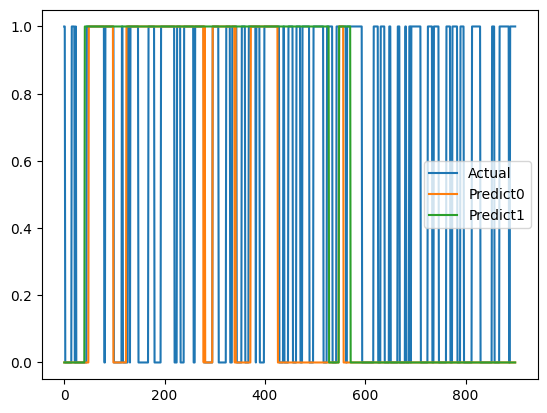

In [ ]:
plt.plot(ex, out0, ex, ans0, ex, ans1)
plt.legend(["Actual", "Predict0", "Predict1"])

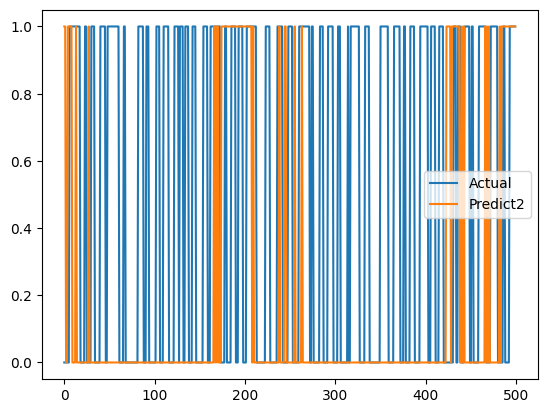

In [ ]:
# plt.plot(ex, out1, ex, ans2)
# plt.legend(["Actual", "Predict2"])

<function matplotlib.pyplot.show(close=None, block=None)>

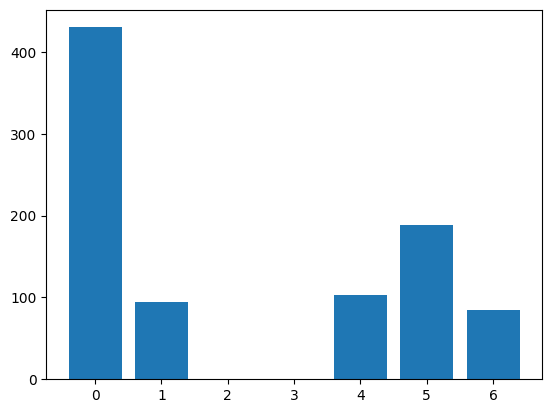

In [ ]:
tally = []
for i in range(len(out0)):
    if out0[i]==ans0[i] and out0[i]==ans1[i]:
      tally.append(0)
    elif out0[i]>ans0[i] and out0[i]==ans1[i]:
      tally.append(1)
    elif out0[i]<ans0[i] and out0[i]==ans1[i]:
      tally.append(2)
    elif out0[i]==ans0[i] and out0[i]>ans1[i]:
      tally.append(3)
    elif out0[i]==ans0[i] and out0[i]<ans1[i]:
      tally.append(4)
    elif out0[i]>ans0[i] and out0[i]>ans1[i]:
      tally.append(5)
    elif out0[i]<ans0[i] and out0[i]<ans1[i]:
      tally.append(6)
    else:
      tally.append(7)

tally = np.array(tally)
bins = np.arange(0, 8)
hist, _ = np.histogram(tally, bins=bins)
plt.bar(bins[:-1], hist)
plt.xticks(bins[:-1])
plt.show